In [108]:
import yfinance as yf
import gymnasium as gym
import gym_anytrading
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DQN
import matplotlib
import pandas as pd
import numpy as np



In [109]:

def fetch_stock_data(ticker_symbol, start_date, end_date, interval):
    """
    Fetches historical stock data for a given ticker symbol and date range.

    Args:
        ticker_symbol (str): The ticker symbol of the stock.
        start_date (str): The start date of the date range (format: "YYYY-MM-DD").
        end_date (str): The end date of the date range (format: "YYYY-MM-DD").

    Returns:
        pandas.DataFrame: The fetched stock data as a DataFrame.
    """
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval=interval)
    return stock_data

# Specify the ticker symbol and the date range
ticker_symbol = "AAPL"
start_date = "2024-04-18"
end_date = "2024-04-24"

# Fetch historical data
stock_data = fetch_stock_data(ticker_symbol, start_date, end_date, interval = "5m" )


[*********************100%%**********************]  1 of 1 completed


In [110]:
stock_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [111]:

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [112]:
env = gym.make('stocks-v0', df=stock_data, frame_bound=(10,100), window_size = 10)

In [113]:
state = env.reset()
while True:
    
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': -1.141876220703125, 'total_profit': 0.7688004395931916, 'position': <Positions.Long: 1>}


/Users/khalidwaya/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_wrapper_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


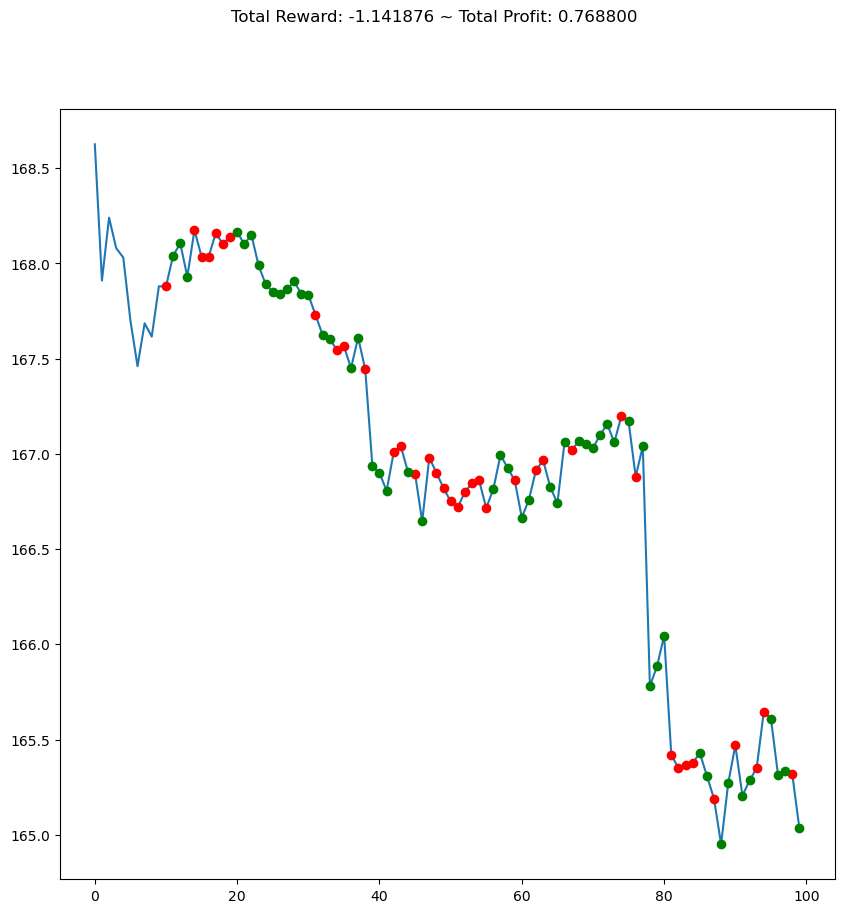

In [114]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.cla()
env.render_all()
plt.show()

In [115]:
print("Data columns:", stock_data.columns)
env_maker = lambda: gym.make('stocks-v0', df=stock_data, frame_bound=(10, 100), window_size=5)
env = DummyVecEnv([env_maker])


Data columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [116]:
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps= 100000)

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1374     |
|    time_elapsed     | 0        |
|    total_timesteps  | 356      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00652  |
|    n_updates        | 63       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1408     |
|    time_elapsed     | 0        |
|    total_timesteps  | 712      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0601   |
|    n_updates        | 152      |
----------------------------------
----------------------------------
| rollout/            |          |
|  

In [117]:
env = gym.make('stocks-v0', df = stock_data, frame_bound=(90,160), window_size = 5)
obs, _ = env.reset()

In [118]:
obs

array([[ 1.6531000e+02, -1.1999512e-01],
       [ 1.6519000e+02, -1.1999512e-01],
       [ 1.6495000e+02, -2.4000549e-01],
       [ 1.6527000e+02,  3.2000732e-01],
       [ 1.6547000e+02,  1.9999695e-01]], dtype=float32)

In [119]:
while True:
    try:
       
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("info", info)
            break
    except TypeError as e:
        print(f"TypeError occurred: {str(e)}")
        print("Please ensure that 'obs' is a numpy array or can be indexed with 'np.newaxis'.")
        break
    except ValueError as e:
        print(f"ValueError occurred: {str(e)}")
        print("Please ensure that 'obs' has the correct shape and dimensions.")
        break
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        break

info {'total_reward': 0.0, 'total_profit': 0.9880014538590314, 'position': <Positions.Long: 1>}


/Users/khalidwaya/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_wrapper_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


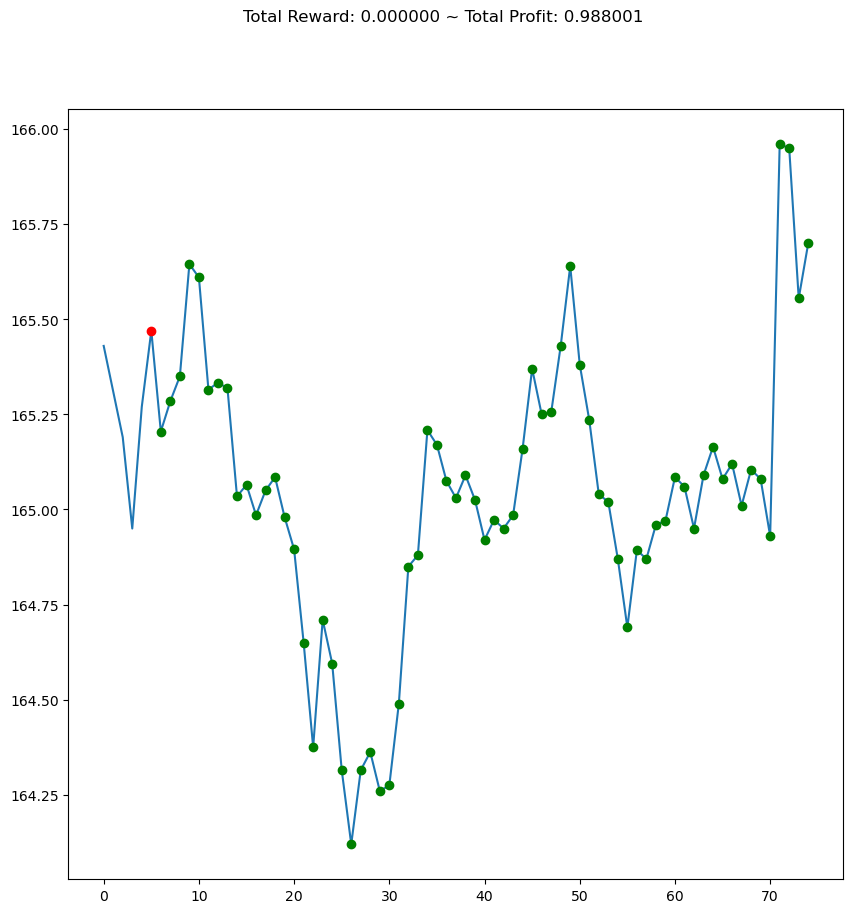

In [120]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.cla()
env.render_all()
plt.show()

In [121]:
model.save("dqn_model")

In [123]:
dq = model.load("dqn_model")